<a href="https://colab.research.google.com/github/peremonzo/Fire_Detection_Saturdays_AI/blob/main/DeteccionIncencios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, r2_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer

# Estudio de las capas, extracción y formateo de datos

In [4]:
drive_path_ainhoa = "/content/drive/MyDrive/Còpia de stack_palancia.tif"
drive_path_pere = "/content/drive/MyDrive/ProyectoSaturdaysDatos/stack_palancia.tif"
drive_path_pere_pend_ori = "/content/drive/MyDrive/ProyectoSaturdaysDatos/pend_ori_stack.tif"
dataset = rasterio.open(drive_path_pere)
dataset_pend_ori = rasterio.open(drive_path_pere_pend_ori)

In [5]:
print('height (alto de las imágenes A): ', dataset.height)
print('width (anchura de las imágenes A): ', dataset.width)

print('height (alto de las imágenes B): ', dataset_pend_ori.height)
print('width (anchura de las imágenes B): ', dataset_pend_ori.width)

height (alto de las imágenes A):  9323
width (anchura de las imágenes A):  9813
height (alto de las imágenes B):  9319
width (anchura de las imágenes B):  9808


## Extracción de los datos de cada capa

In [6]:
band1 = dataset.read(1)[4:, 5:]
band2 = dataset.read(2)[4:, 5:]
band3 = dataset.read(3)[4:, 5:]
band4 = dataset.read(4)[4:, 5:]
band5 = dataset.read(5)[4:, 5:] 
band6 = dataset_pend_ori.read(1)
band7 = dataset_pend_ori.read(2)

In [7]:
print(band1.shape == band2.shape == band3.shape == band4.shape == band5.shape == band6.shape == band7.shape)

True


## Creación del data frame (columnas = capas y filas = valor del píxel)

In [8]:
# creando la matriz de datos (columnas=capas y filas=valor_pixel)
m = np.vstack([
      band1.ravel().transpose(),
      band2.ravel().transpose(),
      band3.ravel().transpose(),
      band4.ravel().transpose(),
      band5.ravel().transpose(),
      band6.ravel().transpose(),
      band7.ravel().transpose()
    ]).transpose()
print(m.shape)

(91400752, 7)


In [9]:
#creando data frame
df = pd.DataFrame(m, columns=['municipios','carreteras','agraria','temperatura','fuego', 'pendiente', 'orientacion'])

In [10]:
print(df.municipios.value_counts())

-1000000000    52598054
-999999999     38408259
 1               394439
Name: municipios, dtype: int64


In [11]:
print(df.carreteras.value_counts())

-1000000000    52256010
-999999999     38408259
 1               736483
Name: carreteras, dtype: int64


In [12]:
print(df.agraria.value_counts())

-999999999     38408259
 8             13323871
 12             6283185
 10             4577028
 9              4031137
 7              3908138
 1              3689812
 13             2756089
 101            1991765
 14             1458298
 6              1367823
 108            1325790
 201             953437
 102             856912
 17              741256
 117             707645
 109             702160
 11              477112
 107             458376
 2               436126
 3               417452
 5               307274
 106             291368
 112             226005
 18              213607
 202             187984
 21              150130
 16              146283
 217             135630
 208             126236
 110             116938
 103             112309
 113              96117
 20               67167
 206              65407
 203              55489
 207              33311
 114              29395
 4                22307
 209              20777
 210              17920
 212            

In [13]:
print(df.temperatura.value_counts())

-999999999     38408259
-1000000000       30885
 47263            20606
 47591            20447
 47120            20433
                 ...   
 50712               36
 44160               36
 50688               36
 50776               36
 43726               36
Name: temperatura, Length: 6923, dtype: int64


In [14]:
print(df.fuego.value_counts())

-999999999     38408259
-1000000000    36228088
 50             6938342
 80             4052154
 0              3909060
 30             1068344
 60              342528
 20              324210
 40               71223
 70               42020
 10               12504
 90                3256
 100                756
 95                   8
Name: fuego, dtype: int64


In [15]:
print(df.pendiente.value_counts())

-9999    38408102
 4        1036855
 5        1021123
 3        1000771
 6         997494
           ...   
 786            1
 842            1
 680            1
 734            1
 615            1
Name: pendiente, Length: 816, dtype: int64


In [16]:
print(df.orientacion.value_counts())

0      38563718
135      172302
134      171211
145      171054
148      170918
         ...   
285      114891
286      114782
287      114695
284      114431
360       71900
Name: orientacion, Length: 361, dtype: int64


In [17]:
# Nos aseguramos que todos píxeles de sin datos son -999999999
print(len(df[(df.municipios == -999999999) & (
            (df.carreteras != -999999999) | 
            (df.agraria != -999999999) | 
            (df.temperatura != -999999999) | 
            (df.fuego != -999999999) | 
            (df.pendiente != -9999) |
            (df.orientacion != 0) )]))

25122


## Formateo de los píxeles de la capa de incendios

### Eliminamos los campos "sin datos"

In [18]:
#eliminamos los -999999999 que son los valores sin datos
df.drop(df[(df.fuego == -999999999) | (df.pendiente == -9999) | (df.orientacion == 0)].index,inplace=True)

print(df.shape)

(52811944, 7)


In [19]:
print(-999999999 in df.municipios.value_counts())
print(-999999999 in df.carreteras.value_counts())
print(-999999999 in df.agraria.value_counts())
print(-999999999 in df.temperatura.value_counts())
print(-999999999 in df.fuego.value_counts())
print(-9999 in df.pendiente.value_counts())
print(0 in df.orientacion.value_counts())

False
False
False
False
False
False
False


### Gestionamos las categorías de la capa de incendios

In [20]:
print(df.fuego.value_counts())

-1000000000    36076909
 50             6925974
 80             4044703
 0              3902115
 30             1067039
 60              342058
 20              323550
 40               71098
 70               42000
 10               12480
 90                3256
 100                754
 95                   8
Name: fuego, dtype: int64


In [21]:
#juntamos los -1000000000 y los 0 que son valores donde no ha habido incendios o la probabilidad de ignición es nula 
df['fuego'] = df['fuego'].replace(-1000000000, 0)

In [22]:
# Reemplazamos los valores por su capacidad de ignicion.
# (0) Los valores a 0 serán nulos
# (1) Los valores entre 01 y 25 son una probabilidad baja de incencio
# (2) Los valores entre 26 y 50 son una probabilidad media de incencio
# (3) Los valores entre 51 y 75 son una probabilidad alta de incencio
# (4) Los valores entre 76 y 100 son una probabilidad extrema de incencio

df['fuego'] = df['fuego'].where(~df['fuego'].between(1, 25), 1)
df['fuego'] = df['fuego'].where(~df['fuego'].between(26, 50), 2)
df['fuego'] = df['fuego'].where(~df['fuego'].between(51, 75), 3)
df['fuego'] = df['fuego'].where(~df['fuego'].between(76, 100), 4)

# df['fuego'] = df['fuego'].where(~df['fuego'].between(1, 25), 1)
# df['fuego'] = df['fuego'].where(~df['fuego'].between(26, 50), 1)
# df['fuego'] = df['fuego'].where(~df['fuego'].between(51, 75), 2)
# df['fuego'] = df['fuego'].where(~df['fuego'].between(76, 100), 2)

# df['fuego'] = df['fuego'].where(~df['fuego'].between(1, 33), 1)
# df['fuego'] = df['fuego'].where(~df['fuego'].between(34, 66), 2)
# df['fuego'] = df['fuego'].where(~df['fuego'].between(67, 100), 3)

In [23]:
print(df.fuego.value_counts())

0    39979024
2     8064111
4     4048721
3      384058
1      336030
Name: fuego, dtype: int64


## Balanceamos el DataFrame

In [24]:
df.shape

(52811944, 7)

In [25]:
# Como está desvalanceado el data frame, vamos a balancearlo
n_samples = 200000

# Submuestrea aleatoriamente las observaciones de las clases sobrerrepresentadas
balanced = pd.concat([
    resample(df[df['fuego'] == class_], replace=False, n_samples=n_samples)
    for class_ in df['fuego'].unique()
])

# Especifica el porcentaje deseado de cada clase
# percent_to_keep = 0.03

# # Submuestrea aleatoriamente las observaciones de las clases sobrerrepresentadas
# balanced = pd.concat([
#     resample(df[df['fuego'] == class_], replace=False, 
#              n_samples=int(df[df['fuego'] == class_].shape[0] * percent_to_keep))
#     for class_ in df['fuego'].unique()
# ])

In [26]:
# Finalmente vemos que nos quedamos con 500.000 píxeles, 100.000 por cada probabilidad de ignición
print(balanced.fuego.value_counts())
print(balanced.shape)

0    200000
3    200000
2    200000
1    200000
4    200000
Name: fuego, dtype: int64
(1000000, 7)


## Formateamos datos de la capa de municipios, carreteras y agraria

In [27]:
# cambiamos el valor 'sin municipios' de -1.000.000.000 por 0 para tener capas binarias
balanced.loc[balanced.municipios != 1, 'municipios'] = 0
balanced.loc[balanced.carreteras != 1, 'carreteras'] = 0
balanced.loc[balanced.agraria == -1000000000, 'agraria'] = 0

In [28]:
print(balanced.municipios.value_counts())
print()
print(balanced.carreteras.value_counts())
print()
print(balanced.agraria.value_counts())
print()
print(balanced.pendiente.value_counts())
print()
print(balanced.orientacion.value_counts())

0    997130
1      2870
Name: municipios, dtype: int64

0    990584
1      9416
Name: carreteras, dtype: int64

8      378156
10     181283
1       92119
7       91738
9       36291
6       34758
12      32264
108     24694
101     22447
13      14149
17       9382
102      9247
3        9225
14       7694
2        7208
201      6769
117      5560
107      5542
109      5482
110      3782
106      3052
11       2391
208      1686
5        1649
103      1632
202      1626
18       1584
20       1328
112      1128
217      1018
21        957
203       594
113       477
210       464
4         448
206       442
16        358
207       334
118       165
204       153
209       136
114       133
104        95
212        92
0          77
218        63
111        61
213        42
211         7
214         7
105         4
116         3
115         2
219         1
215         1
Name: agraria, dtype: int64

31     17568
34     17486
35     17306
33     17283
37     17164
       ...  
449        

# Análisis de datos

## Matriz de correlaciones

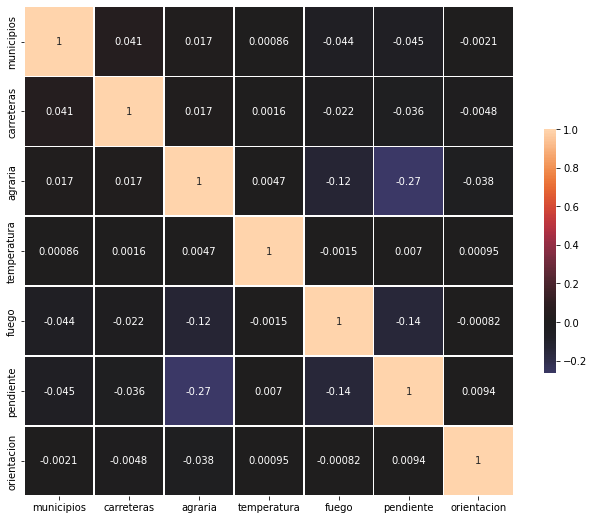

In [29]:
corr = balanced.corr()
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

# Definimos y entrenamos el modelo

In [30]:
X=balanced[['municipios', 'carreteras', 'agraria', 'temperatura', 'pendiente', 'orientacion']]
y=balanced.fuego

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
#liberamos ram
del dataset
del dataset_pend_ori

del band1
del band2
del band3
del band4
del band5
del band6
del band7


In [ ]:
forest = RandomForestClassifier(random_state=0, n_estimators=150,max_depth=30,max_features=3)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print('Accuracy is',accuracy_score(y_pred,y_test))


In [61]:
y_pred = forest.predict(X_test)
print('Accuracy is',accuracy_score(y_pred,y_test))

Accuracy is 0.721125


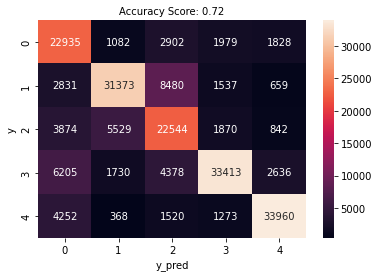

In [62]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_pred, y_test)

In [63]:
print(classification_report(y_true = y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.75      0.57      0.65     40097
           1       0.70      0.78      0.74     40082
           2       0.65      0.57      0.61     39824
           3       0.69      0.83      0.76     40072
           4       0.82      0.85      0.84     39925

    accuracy                           0.72    200000
   macro avg       0.72      0.72      0.72    200000
weighted avg       0.72      0.72      0.72    200000



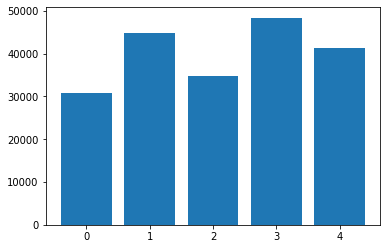

In [64]:
from collections import Counter

frecuencia = Counter(y_pred)

plt.bar(frecuencia.keys(), frecuencia.values())
plt.show()

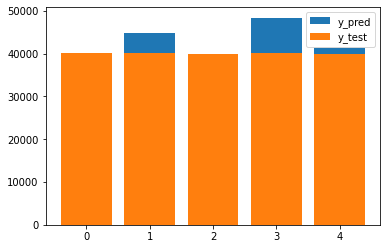

In [65]:
x1 = Counter(y_pred)
x2 = Counter(y_test)

fig, ax = plt.subplots()

ax.bar(x1.keys(), x1.values(), label='y_pred')
ax.bar(x2.keys(), x2.values(), label='y_test')

ax.legend()

plt.show()